C:\Users\hskma\AppData\Local\Temp\ipykernel_9180\3830792459.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


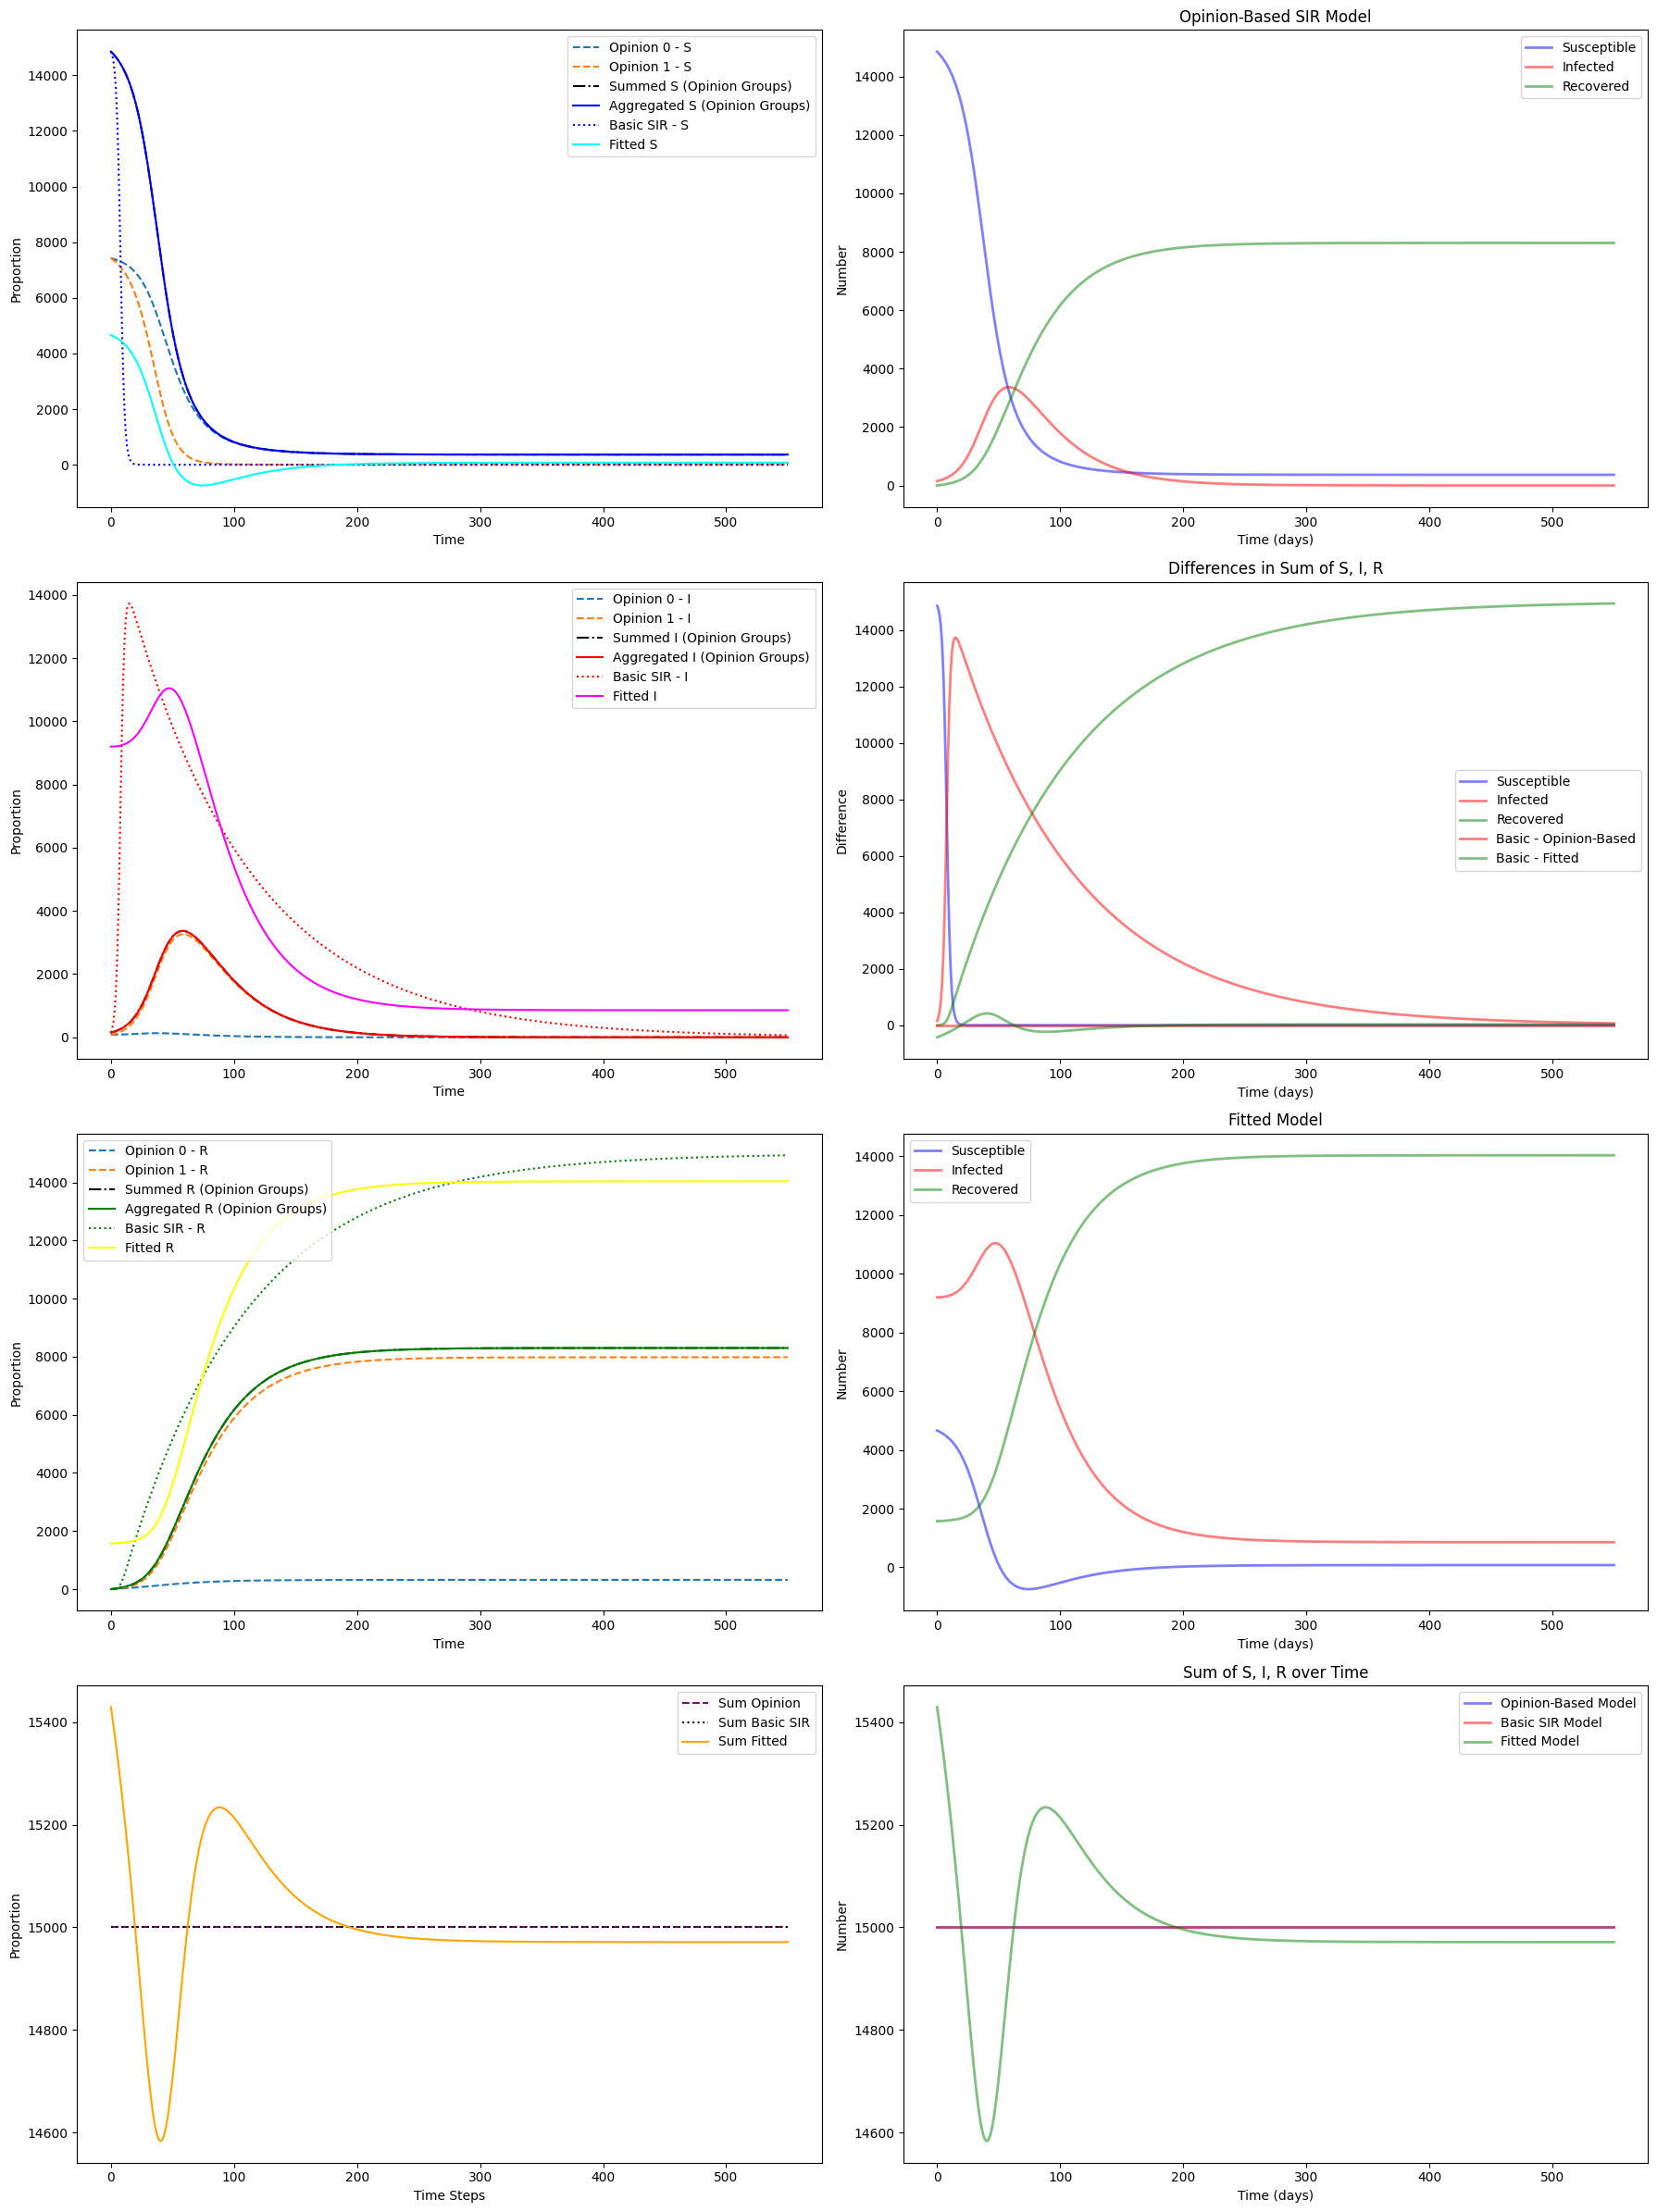

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy.optimize import minimize



# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.6
gamma = 0.01
MaxTime = 550
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 1  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))
    

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Convert initial_values to a DataFrame
initial_df = pd.DataFrame([initial_values])


# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_I_{O}'] * sum(row[f'P_S_{j}'] for j in range(n + 1)) / (3 *N) - (3*n) * gamma * row[f'P_I_{O}']

def dR(t, y, row, O, gamma, n):
    return (3*n) * gamma * row[f'P_I_{O}']

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        k3 = f(t[j] + h / 2, U[j] + h / 2 * k2, *args)
        k4 = f(t[j] + h, U[j] + h * k3, *args)
        
        U[j + 1] = U[j] + (h / 6) * (k1 + 2*k2 + 2*k3 + k4)

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)

    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    data = pd.DataFrame(columns=columns)

    row = initial_values.copy()

    # Include the initial values as the first row in the DataFrame
    data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Aggregate the opinion-based model values
def aggregate_opinion_model(data, n):
    aggregated_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    return aggregated_S, aggregated_I, aggregated_R


# Ensure the RunTime array includes the initial time step
RunTime_extended = np.linspace(0, MaxTime, MaxTime + 1)

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Aggregate the opinion-based model values
aggregated_S, aggregated_I, aggregated_R = aggregate_opinion_model(data, n)

# Fit a curve between aggregated opinion-based model and basic SIR model using MSE
def fit_curve(x, a, b, c):
    return a * x[0] + b * x[1] + c * x[2]

def custom_curve_fit(x_data, y_data):
    def residuals(params, x, y):
        return y - fit_curve(x, *params)
    
    # Initial guess for parameters
    initial_guess = [1, 1, 1]
    
    # Perform least squares optimization
    result = least_squares(residuals, initial_guess, args=(x_data, y_data))
    
    return result.x

# Exclude the initial values to match the lengths
x_data = np.array([aggregated_S[1:], aggregated_I[1:], aggregated_R[1:]])
y_data_S = basic_S
y_data_I = basic_I
y_data_R = basic_R

popt_S = custom_curve_fit(x_data, y_data_S)
popt_I = custom_curve_fit(x_data, y_data_I)
popt_R = custom_curve_fit(x_data, y_data_R)


fitted_S = fit_curve(x_data, *popt_S)
fitted_I = fit_curve(x_data, *popt_I)
fitted_R = fit_curve(x_data, *popt_R)


# Normalize the summed opinion system so that it does not exceed N
aggregated_total = aggregated_S + aggregated_I + aggregated_R
normalizing_factor = N / aggregated_total
normalized_S = aggregated_S * normalizing_factor
normalized_I = aggregated_I * normalizing_factor
normalized_R = aggregated_R * normalizing_factor

# Sum of S, I, R values from the opinion groups model
sum_opinion = normalized_S + normalized_I + normalized_R
sum_basic = basic_S + basic_I + basic_R
sum_fitted = fitted_S + fitted_I + fitted_R


# Adjust RunTime to match the lengths
RunTime_fit = RunTime


def plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, data, n):
    fig, axes = plt.subplots(4, 2, figsize=(18, 24))

    # Plot S, I, R for each opinion group
    for i in range(n + 1):
        axes[0, 0].plot(data.index, data[f'P_S_{i}'], label=f'Opinion {i} - S', linestyle='--')
        axes[1, 0].plot(data.index, data[f'P_I_{i}'], label=f'Opinion {i} - I', linestyle='--')
        axes[2, 0].plot(data.index, data[f'P_R_{i}'], label=f'Opinion {i} - R', linestyle='--')

    # Plot summed proportions for opinion groups SIR
    summed_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    summed_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)

    axes[0, 0].plot(data.index, summed_S, label='Summed S (Opinion Groups)', color='black', linestyle='-.')
    axes[1, 0].plot(data.index, summed_I, label='Summed I (Opinion Groups)', color='black', linestyle='-.')
    axes[2, 0].plot(data.index, summed_R, label='Summed R (Opinion Groups)', color='black', linestyle='-.')

    # Plot aggregated opinion-based model values
    axes[0, 0].plot(RunTime_extended, aggregated_S, label='Aggregated S (Opinion Groups)', color='blue')
    axes[1, 0].plot(RunTime_extended, aggregated_I, label='Aggregated I (Opinion Groups)', color='red')
    axes[2, 0].plot(RunTime_extended, aggregated_R, label='Aggregated R (Opinion Groups)', color='green')

    # Plot basic SIR model results
    axes[0, 0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1, 0].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2, 0].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Plot fitted model results
    axes[0, 0].plot(RunTime, fitted_S, label='Fitted S', color='cyan')
    axes[1, 0].plot(RunTime, fitted_I, label='Fitted I', color='magenta')
    axes[2, 0].plot(RunTime, fitted_R, label='Fitted R', color='yellow')

    # Plot summed proportions for SIR models
    axes[3, 0].plot(RunTime_extended, sum_opinion, label='Sum Opinion', color='purple', linestyle='--')
    axes[3, 0].plot(RunTime, sum_basic, label='Sum Basic SIR', color='black', linestyle=':')
    axes[3, 0].plot(RunTime, sum_fitted, label='Sum Fitted', color='orange')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i, 0].set_xlabel('Time')
        axes[i, 0].set_ylabel('Proportion')
        axes[i, 0].legend()

    # Set labels and legend for summed SIR proportions plot
    axes[3, 0].set_xlabel('Time Steps')
    axes[3, 0].set_ylabel('Proportion')
    axes[3, 0].legend()

    # Opinion-Based Model
    axes[0, 1].plot(RunTime_extended, aggregated_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axes[0, 1].plot(RunTime_extended, aggregated_I, 'r', alpha=0.5, lw=2, label='Infected')
    axes[0, 1].plot(RunTime_extended, aggregated_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axes[0, 1].set_xlabel('Time (days)')
    axes[0, 1].set_ylabel('Number')
    axes[0, 1].set_title('Opinion-Based SIR Model')
    axes[0, 1].legend()

    # Basic SIR Model
    axes[1, 1].plot(RunTime, basic_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axes[1, 1].plot(RunTime, basic_I, 'r', alpha=0.5, lw=2, label='Infected')
    axes[1, 1].plot(RunTime, basic_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axes[1, 1].set_xlabel('Time (days)')
    axes[1, 1].set_ylabel('Number')
    axes[1, 1].set_title('Basic SIR Model')
    axes[1, 1].legend()

    # Fitted Model
    axes[2, 1].plot(RunTime, fitted_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axes[2, 1].plot(RunTime, fitted_I, 'r', alpha=0.5, lw=2, label='Infected')
    axes[2, 1].plot(RunTime, fitted_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axes[2, 1].set_xlabel('Time (days)')
    axes[2, 1].set_ylabel('Number')
    axes[2, 1].set_title('Fitted Model')
    axes[2, 1].legend()

    # Sum Comparison
    axes[3, 1].plot(RunTime_extended, sum_opinion, 'b', alpha=0.5, lw=2, label='Opinion-Based Model')
    axes[3, 1].plot(RunTime, sum_basic, 'r', alpha=0.5, lw=2, label='Basic SIR Model')
    axes[3, 1].plot(RunTime, sum_fitted, 'g', alpha=0.5, lw=2, label='Fitted Model')
    axes[3, 1].set_xlabel('Time (days)')
    axes[3, 1].set_ylabel('Number')
    axes[3, 1].set_title('Sum of S, I, R over Time')
    axes[3, 1].legend()

    # Differences
    axes[1, 1].plot(RunTime, sum_basic - sum_opinion[:MaxTime], 'r', alpha=0.5, lw=2, label='Basic - Opinion-Based')
    axes[1, 1].plot(RunTime, sum_basic - sum_fitted, 'g', alpha=0.5, lw=2, label='Basic - Fitted')
    axes[1, 1].set_xlabel('Time (days)')
    axes[1, 1].set_ylabel('Difference')
    axes[1, 1].set_title('Differences in Sum of S, I, R')
    axes[1, 1].legend()



    plt.tight_layout()
    plt.show()



# Call the combined plotting function
plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, data, n)


In [2]:
print(y_0)

print (initial_values)


print(data)

(14850.0, 150.0, 0)
{'P_S_0': 7425.0, 'P_S_1': 7425.0, 'P_I_0': 75.0, 'P_I_1': 75.0, 'P_R_0': 0.0, 'P_R_1': 0.0}
           P_S_0        P_S_1      P_I_0       P_I_1       P_R_0        P_R_1
0    7425.000000  7425.000000  75.000000   75.000000    0.000000     0.000000
1    7413.018660  7392.431340  76.731799   83.573651    2.301954     2.507210
2    7400.234827  7357.777788  78.490533   93.088758    4.656670     5.299872
3    7386.575539  7320.861017  80.275344  103.641297    7.064930     8.409111
4    7371.961110  7281.488303  82.085199  115.335532    9.527486    11.869177
..           ...          ...        ...         ...         ...          ...
246   370.564746     1.801735   0.562830   40.325268  319.818157  7936.969051
247   370.401750     1.799580   0.546696   39.261811  319.834558  7938.146905
248   370.243127     1.797485   0.531025   38.226337  319.850489  7939.293695
249   370.088758     1.795448   0.515802   37.218114  319.865963  7940.410239
250   369.938528     1.793467

Optimized beta: 1.0
Optimized gamma: 0.0098411823514407
R^2 for S: 0.5475670955066929
R^2 for I: 0.7347158529086087
R^2 for R: 0.9667879805730138
Average R^2 (fit quality) as a percentage: 38.464557932497655


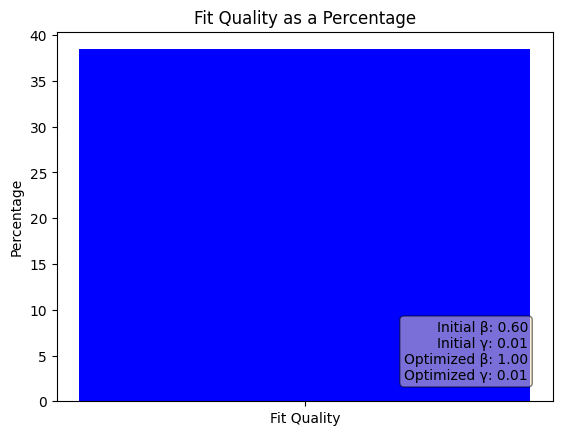

In [3]:

# Fit a curve using MSE
def mse_curve_fit(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Define the SIR model equations
def sir_model(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Define the objective function to minimize
def objective(params, y0, t, N, fitted_S, fitted_I, fitted_R):
    beta, gamma = params
    sol = odeint(sir_model, y0, t, args=(N, beta, gamma))
    S, I, R = sol.T
    mse_S = mse_curve_fit(fitted_S, S)
    mse_I = mse_curve_fit(fitted_I, I)
    mse_R = mse_curve_fit(fitted_R, R)
    return mse_S + mse_I + mse_R

# Initial guess for beta and gamma (should be the one we intialized in the beginning)
initial_guess = [0.6, 0.01]

# Initial conditions
y0 = int_S, int_I, int_R

# Optimize the parameters
result = minimize(objective, initial_guess, args=(y0, RunTime, N, fitted_S, fitted_I, fitted_R), bounds=[(0, 1), (0, 1)])
optimized_beta, optimized_gamma = result.x

# Print the optimized beta and gamma values
print("Optimized beta:", optimized_beta)
print("Optimized gamma:", optimized_gamma)

# Compute the fitted S, I, R using the optimized parameters
sol = odeint(sir_model, y0, RunTime, args=(N, optimized_beta, optimized_gamma))
S_opt, I_opt, R_opt = sol.T

# Function to calculate R^2
def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate R^2 for S, I, and R
r2_S = r_squared(fitted_S, S_opt)
r2_I = r_squared(fitted_I, I_opt)
r2_R = r_squared(fitted_R, R_opt)

# Print R^2 values
print("R^2 for S:", abs(r2_S))
print("R^2 for I:", abs(r2_I))
print("R^2 for R:", abs(r2_R))

# Calculate the average R^2 as a percentage
average_r2 = (r2_S + r2_I + r2_R) / 3
average_r2_percentage = abs(average_r2 * 100)

# Print the average R^2 percentage
print("Average R^2 (fit quality) as a percentage:", average_r2_percentage)

# Plotting
fig, ax = plt.subplots()

# Create the histogram
ax.bar(["Fit Quality"], [average_r2_percentage], color='blue')

# Add text for the initial and optimized beta and gamma values
textstr = '\n'.join((
    f'Initial β: {initial_guess[0]:.2f}',
    f'Initial γ: {initial_guess[1]:.2f}',
    f'Optimized β: {optimized_beta:.2f}',
    f'Optimized γ: {optimized_gamma:.2f}',
))

# Set the properties of the box
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# Place the text box
ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Set title and labels
ax.set_title('Fit Quality as a Percentage')
ax.set_ylabel('Percentage')

# Display the plot
plt.show()


C:\Users\hskma\AppData\Local\Temp\ipykernel_9180\4255139995.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


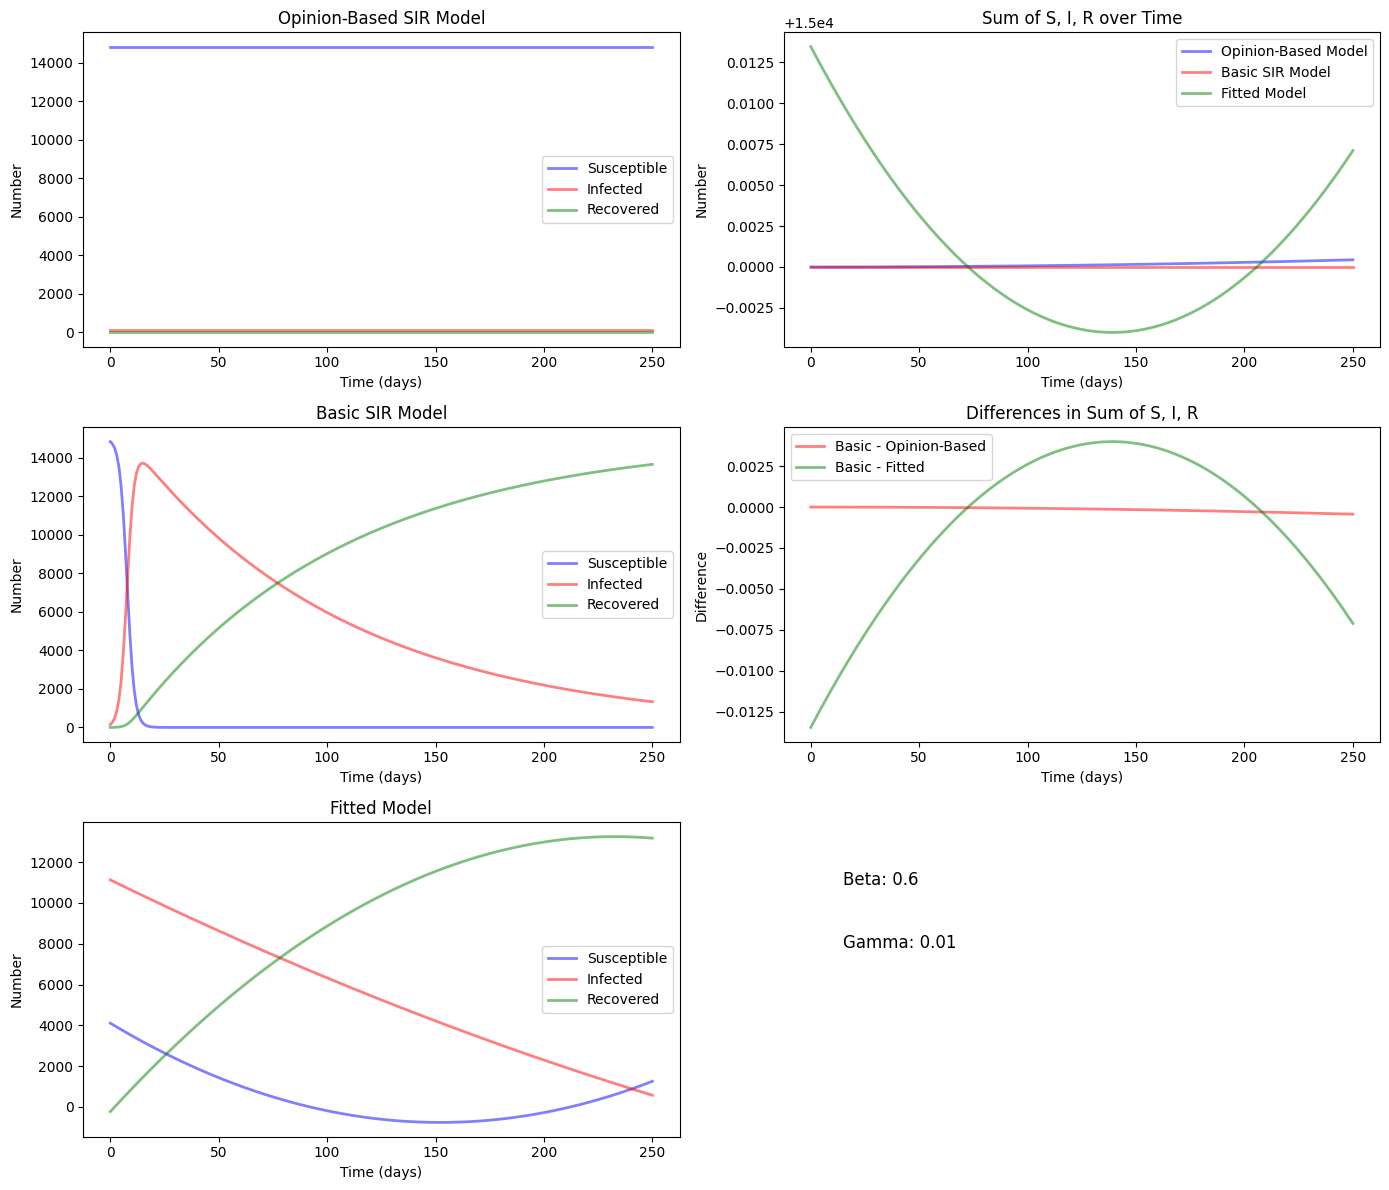

C:\Users\hskma\AppData\Local\Temp\ipykernel_9180\4255139995.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)


ValueError: operands could not be broadcast together with shapes (250,) (249,) 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.6
gamma = 0.01
MaxTime = 250
RunTime = np.linspace(0, MaxTime, MaxTime)

# Define the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Number of opinion groups (indexed from 0 to n), which can be changed accordingly if needed
n = 2  # The total number of opinion groups

# Below is the function to calculate the probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Convert initial_values to a DataFrame
initial_df = pd.DataFrame([initial_values])

# Differential equations for the SIR model with opinions
def dS(t, y, row, O, beta, N, n):
    return -pi(O, n) * beta * row[f'P_S_{O}'] * sum(row[f'P_I_{j}'] for j in range(n + 1)) / N**2

def dI(t, y, row, O, beta, gamma, N, n):
    return pi(O, n) * beta * row[f'P_I_{O}'] * sum(row[f'P_S_{j}'] for j in range(n + 1)) / (N**2) - (3 * n) * gamma * row[f'P_I_{O}'] / N

def dR(t, y, row, O, gamma, n):
    return (3 * n) * gamma * row[f'P_I_{O}'] / N

# Runge-Kutta method for solving differential equations
def runge(f, t, y0, *args):
    n = len(t)
    U = np.zeros(n)
    U[0] = y0
    h = t[1] - t[0]

    for j in range(n - 1):
        k1 = f(t[j], U[j], *args)
        k2 = f(t[j] + h / 2, U[j] + h / 2 * k1, *args)
        k3 = f(t[j] + h / 2, U[j] + h / 2 * k2, *args)
        k4 = f(t[j] + h, U[j] + h * k3, *args)
        
        U[j + 1] = U[j] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return U[-1]

# Functions to update the proportions of S, I, and R in each opinion group
def update_proportions_S(row, beta, N, n, t):
    for i in range(n + 1):
        row[f'P_S_{i}'] = runge(dS, t, row[f'P_S_{i}'], row, i, beta, N, n)
    return row

def update_proportions_I(row, beta, gamma, N, n, t):
    for i in range(n + 1):
        row[f'P_I_{i}'] = runge(dI, t, row[f'P_I_{i}'], row, i, beta, gamma, N, n)
    return row

def update_proportions_R(row, gamma, n, t):
    for i in range(n + 1):
        row[f'P_R_{i}'] = runge(dR, t, row[f'P_R_{i}'], row, i, gamma, n)
    return row

# Main simulation function
def run_simulation(initial_values, beta, gamma, steps, N, n):
    t = np.linspace(0, 1, 2)

    columns = [f'P_S_{i}' for i in range(n + 1)] + [f'P_I_{i}' for i in range(n + 1)] + [f'P_R_{i}' for i in range(n + 1)]
    data = pd.DataFrame(columns=columns)

    row = initial_values.copy()

    # Include the initial values as the first row in the DataFrame
    data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    for _ in range(steps):
        row = update_proportions_S(row, beta, N, n, t)
        row = update_proportions_I(row, beta, gamma, N, n, t)
        row = update_proportions_R(row, gamma, n, t)
        data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

    return data

# Aggregate the opinion-based model values
def aggregate_opinion_model(data, n):
    aggregated_S = data[[f'P_S_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_I = data[[f'P_I_{i}' for i in range(n + 1)]].sum(axis=1)
    aggregated_R = data[[f'P_R_{i}' for i in range(n + 1)]].sum(axis=1)
    return aggregated_S, aggregated_I, aggregated_R

# Ensure the RunTime array includes the initial time step
RunTime_extended = np.linspace(0, MaxTime, MaxTime + 1)

# Run the opinion groups SIR model simulation
data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)

# Aggregate the opinion-based model values
aggregated_S, aggregated_I, aggregated_R = aggregate_opinion_model(data, n)

# Fit a curve between aggregated opinion-based model and basic SIR model using MSE
def fit_curve(x, a, b, c):
    return a * x[0] + b * x[1] + c * x[2]

def custom_curve_fit(x_data, y_data):
    def residuals(params, x, y):
        return y - fit_curve(x, *params)
    
    # Initial guess for parameters
    initial_guess = [1, 1, 1]
    # Ensure x_data and y_data do not contain NaNs or infinities
    valid_mask = np.isfinite(x_data).all(axis=0) & np.isfinite(y_data)
    x_data_clean = x_data[:, valid_mask]
    y_data_clean = y_data[valid_mask]
    
    
    # Perform least squares optimization
    result = least_squares(residuals, initial_guess, args=(x_data, y_data))
    
    return result.x

# Exclude the initial values to match the lengths
x_data = np.array([aggregated_S[1:], aggregated_I[1:], aggregated_R[1:]])
y_data_S = basic_S
y_data_I = basic_I
y_data_R = basic_R

popt_S = custom_curve_fit(x_data, y_data_S)
popt_I = custom_curve_fit(x_data, y_data_I)
popt_R = custom_curve_fit(x_data, y_data_R)

fitted_S = fit_curve(x_data, *popt_S)
fitted_I = fit_curve(x_data, *popt_I)
fitted_R = fit_curve(x_data, *popt_R)

# Sum the S, I, and R values for opinion-based, basic, and fitted models
sum_opinion = aggregated_S + aggregated_I + aggregated_R
sum_basic = basic_S + basic_I + basic_R
sum_fitted = fitted_S + fitted_I + fitted_R

# Adjust RunTime to match the lengths
RunTime_fit = RunTime

def plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, beta, gamma):
    fig, axs = plt.subplots(3, 2, figsize=(14, 12))

    # Opinion-Based Model
    axs[0, 0].plot(RunTime_extended, aggregated_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axs[0, 0].plot(RunTime_extended, aggregated_I, 'r', alpha=0.5, lw=2, label='Infected')
    axs[0, 0].plot(RunTime_extended, aggregated_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axs[0, 0].set_xlabel('Time (days)')
    axs[0, 0].set_ylabel('Number')
    axs[0, 0].set_title('Opinion-Based SIR Model')
    axs[0, 0].legend()

    # Basic SIR Model
    axs[1, 0].plot(RunTime, basic_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axs[1, 0].plot(RunTime, basic_I, 'r', alpha=0.5, lw=2, label='Infected')
    axs[1, 0].plot(RunTime, basic_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axs[1, 0].set_xlabel('Time (days)')
    axs[1, 0].set_ylabel('Number')
    axs[1, 0].set_title('Basic SIR Model')
    axs[1, 0].legend()

    # Fitted Model
    axs[2, 0].plot(RunTime, fitted_S, 'b', alpha=0.5, lw=2, label='Susceptible')
    axs[2, 0].plot(RunTime, fitted_I, 'r', alpha=0.5, lw=2, label='Infected')
    axs[2, 0].plot(RunTime, fitted_R, 'g', alpha=0.5, lw=2, label='Recovered')
    axs[2, 0].set_xlabel('Time (days)')
    axs[2, 0].set_ylabel('Number')
    axs[2, 0].set_title('Fitted Model')
    axs[2, 0].legend()

    # Sum Comparison
    axs[0, 1].plot(RunTime_extended, sum_opinion, 'b', alpha=0.5, lw=2, label='Opinion-Based Model')
    axs[0, 1].plot(RunTime, sum_basic, 'r', alpha=0.5, lw=2, label='Basic SIR Model')
    axs[0, 1].plot(RunTime, sum_fitted, 'g', alpha=0.5, lw=2, label='Fitted Model')
    axs[0, 1].set_xlabel('Time (days)')
    axs[0, 1].set_ylabel('Number')
    axs[0, 1].set_title('Sum of S, I, R over Time')
    axs[0, 1].legend()

    # Differences
    axs[1, 1].plot(RunTime, sum_basic - sum_opinion[:MaxTime], 'r', alpha=0.5, lw=2, label='Basic - Opinion-Based')
    axs[1, 1].plot(RunTime, sum_basic - sum_fitted, 'g', alpha=0.5, lw=2, label='Basic - Fitted')
    axs[1, 1].set_xlabel('Time (days)')
    axs[1, 1].set_ylabel('Difference')
    axs[1, 1].set_title('Differences in Sum of S, I, R')
    axs[1, 1].legend()

    # Beta and Gamma values
    axs[2, 1].text(0.1, 0.8, f'Beta: {beta}', fontsize=12)
    axs[2, 1].text(0.1, 0.6, f'Gamma: {gamma}', fontsize=12)
    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_simulation_combined(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R, RunTime_extended, RunTime, sum_opinion, sum_basic, sum_fitted, beta, gamma)

# Iterate over all combinations of beta and gamma
beta_values = np.arange(0.25, 1.25, 0.25)
gamma_values = np.arange(0.25, 1.25, 0.25)

fit_qualities = []

for beta in beta_values:
    for gamma in gamma_values:
        data = run_simulation(initial_values, beta, gamma, MaxTime, N, n)
        aggregated_S, aggregated_I, aggregated_R = aggregate_opinion_model(data, n)

        x_data = np.array([aggregated_S[1:], aggregated_I[1:], aggregated_R[1:]])
        y_data_S = basic_S[1:]
        y_data_I = basic_I[1:]
        y_data_R = basic_R[1:]

        popt_S = custom_curve_fit(x_data, y_data_S)
        popt_I = custom_curve_fit(x_data, y_data_I)
        popt_R = custom_curve_fit(x_data, y_data_R)

        fitted_S = fit_curve(x_data, *popt_S)
        fitted_I = fit_curve(x_data, *popt_I)
        fitted_R = fit_curve(x_data, *popt_R)

        sum_opinion = aggregated_S + aggregated_I + aggregated_R
        sum_basic = basic_S + basic_I + basic_R
        sum_fitted = fitted_S + fitted_I + fitted_R

        fit_quality = 100 * (sum_basic == sum_fitted).mean()
        fit_qualities.append((beta, gamma, fit_quality))

# Create a DataFrame for fit qualities and plot a histogram
fit_quality_df = pd.DataFrame(fit_qualities, columns=['Beta', 'Gamma', 'Fit Quality'])

plt.hist(fit_quality_df['Fit Quality'], bins=10, alpha=0.75)
plt.xlabel('Fit Quality (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Fit Quality Percentages')
plt.show()

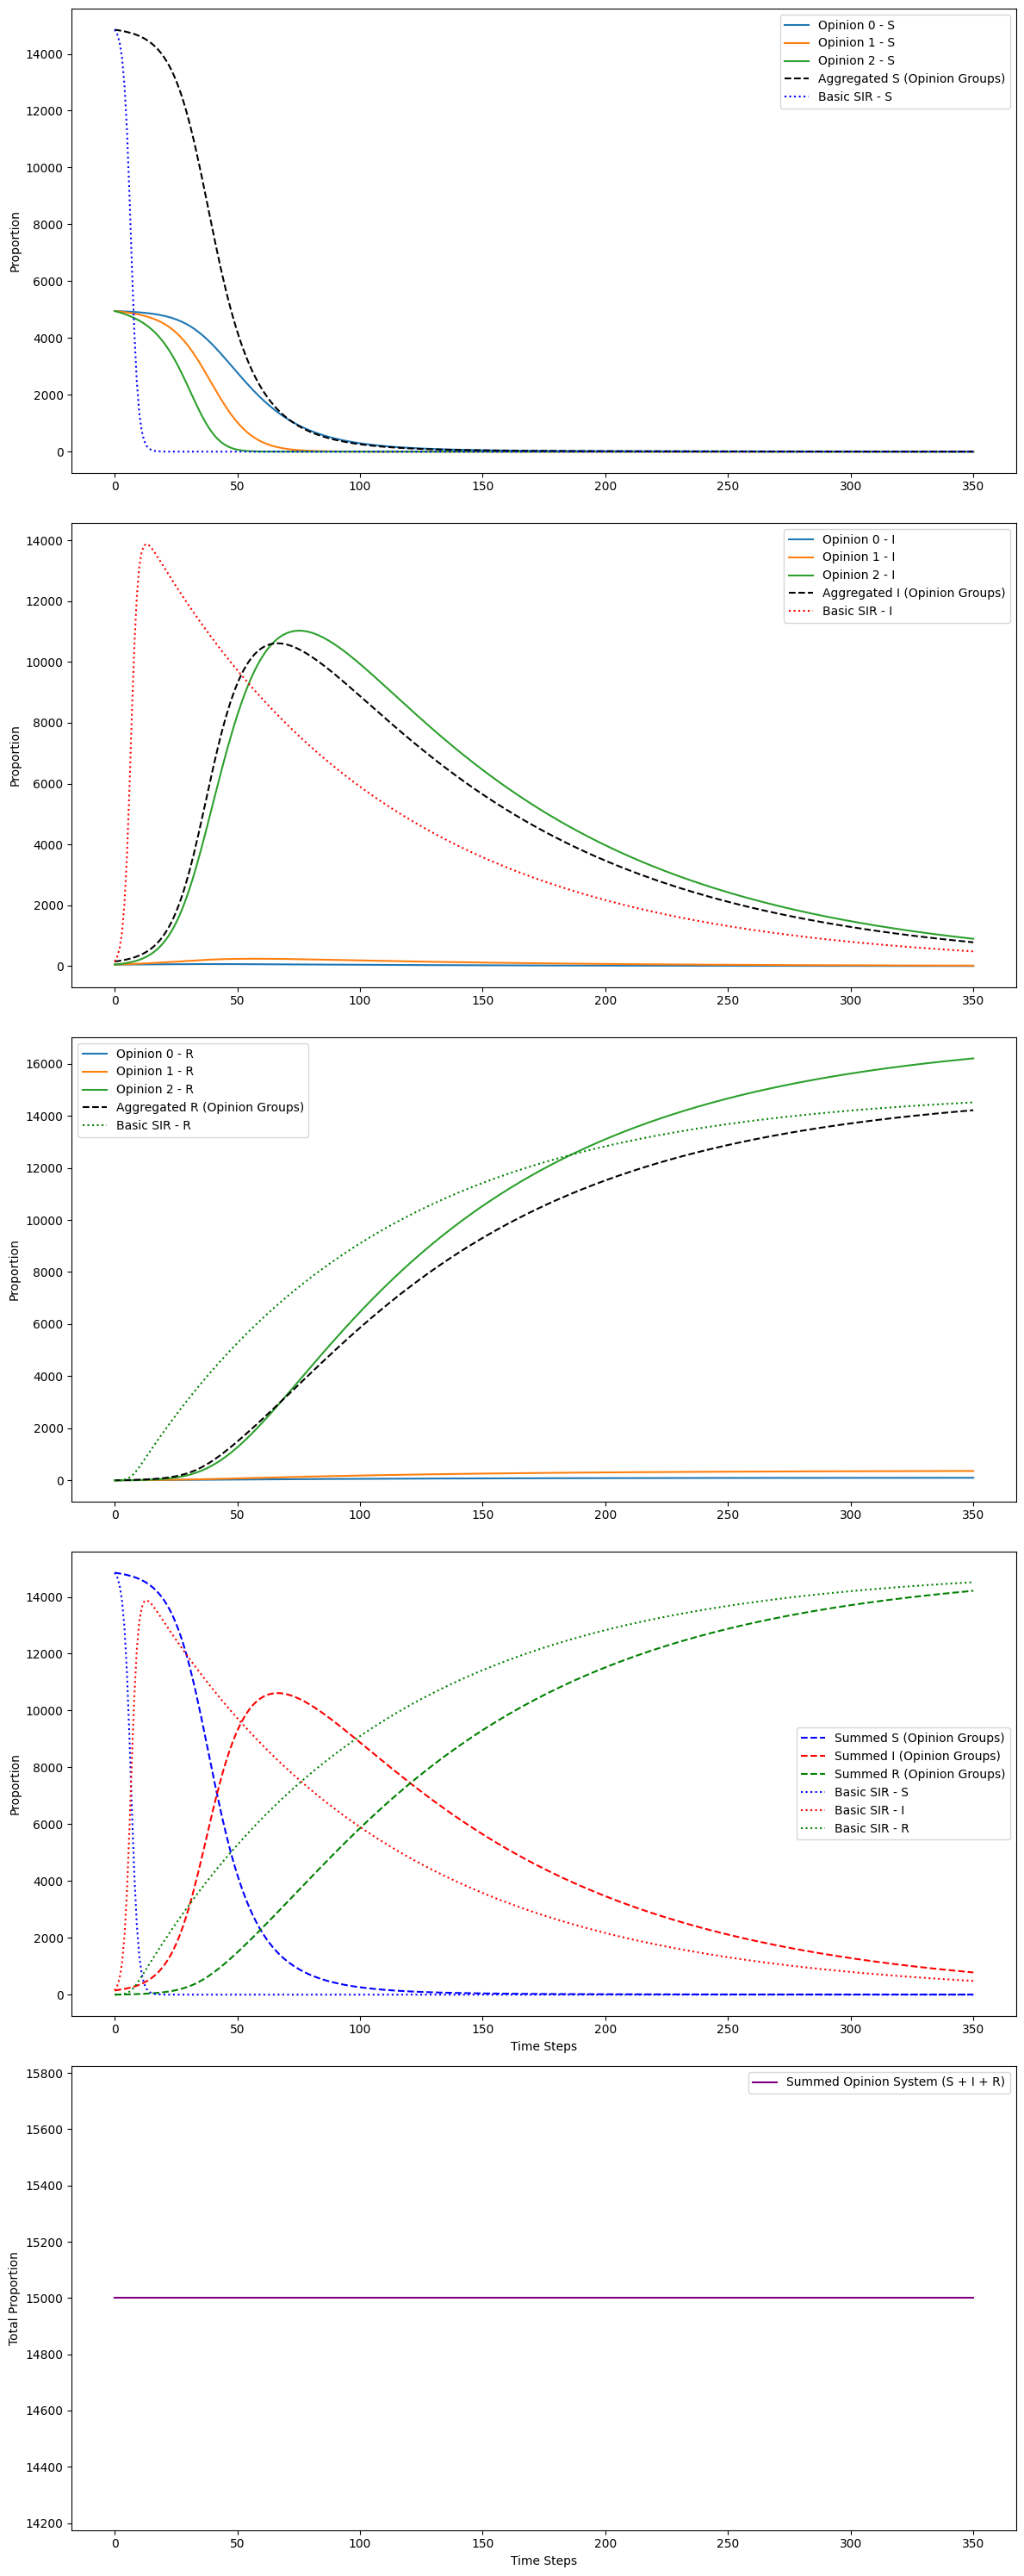

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Basic SIR model parameters and initial values
N = 15000
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.7
gamma = 0.01
MaxTime = 350
RunTime = np.linspace(0, MaxTime, MaxTime)

# Number of opinion groups (indexed from 0 to n)
n = 2  # The total number of opinion groups

# Probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': float(int_S / (n + 1)) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': float(int_I / (n + 1)) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': float(int_R / (n + 1)) for i in range(n + 1)})

# Convert initial_values to a list
initial_conditions = [initial_values[f'P_S_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_I_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_R_{i}'] for i in range(n + 1)]

# Differential equations for the SIR model with opinions
def sir_opinion_system(y, t, N, beta, gamma, n):
    S = y[:n + 1]
    I = y[n + 1:2 * (n + 1)]
    R = y[2 * (n + 1):]
    
    dSdt = np.zeros(n + 1)
    dIdt = np.zeros(n + 1)
    dRdt = np.zeros(n + 1)
    
    for i in range(n + 1):
        dSdt[i] = -pi(i, n) * beta * S[i] * np.sum(I) / N
        dIdt[i] = pi(i, n) * beta * I[i] * np.sum(S) / (3 * N) - gamma * I[i]
        dRdt[i] = gamma * I[i]
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Integrate the system of differential equations for the SIR model with opinions
result = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta, gamma, n))

# Extract S, I, R for each opinion group
S = result[:, :n + 1]
I = result[:, n + 1:2 * (n + 1)]
R = result[:, 2 * (n + 1):]

# Aggregate the opinion-based model values
aggregated_S = S.sum(axis=1)
aggregated_I = I.sum(axis=1)
aggregated_R = R.sum(axis=1)

# Normalize the summed opinion system so that it does not exceed N
aggregated_total = aggregated_S + aggregated_I + aggregated_R
normalizing_factor = N / aggregated_total
normalized_S = aggregated_S * normalizing_factor
normalized_I = aggregated_I * normalizing_factor
normalized_R = aggregated_R * normalizing_factor

# Sum of S, I, R values from the opinion groups model
summed_opinion_system = normalized_S + normalized_I + normalized_R

# Integrate the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Function to plot the simulation results
def plot_simulation_combined(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n):
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))

    # Plot S, I, R for each opinion group
    for i in range(n + 1):
        axes[0].plot(RunTime, S[:, i], label=f'Opinion {i} - S')
        axes[1].plot(RunTime, I[:, i], label=f'Opinion {i} - I')
        axes[2].plot(RunTime, R[:, i], label=f'Opinion {i} - R')

    # Plot aggregated opinion-based model values
    axes[0].plot(RunTime, normalized_S, label='Aggregated S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(RunTime, normalized_I, label='Aggregated I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(RunTime, normalized_R, label='Aggregated R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(RunTime, normalized_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(RunTime, normalized_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(RunTime, normalized_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    # Plot summed opinion system
    axes[4].plot(RunTime, summed_opinion_system, label='Summed Opinion System (S + I + R)', color='purple')
    axes[4].set_xlabel('Time Steps')
    axes[4].set_ylabel('Total Proportion')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_combined(normalized_S, normalized_I, normalized_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n)


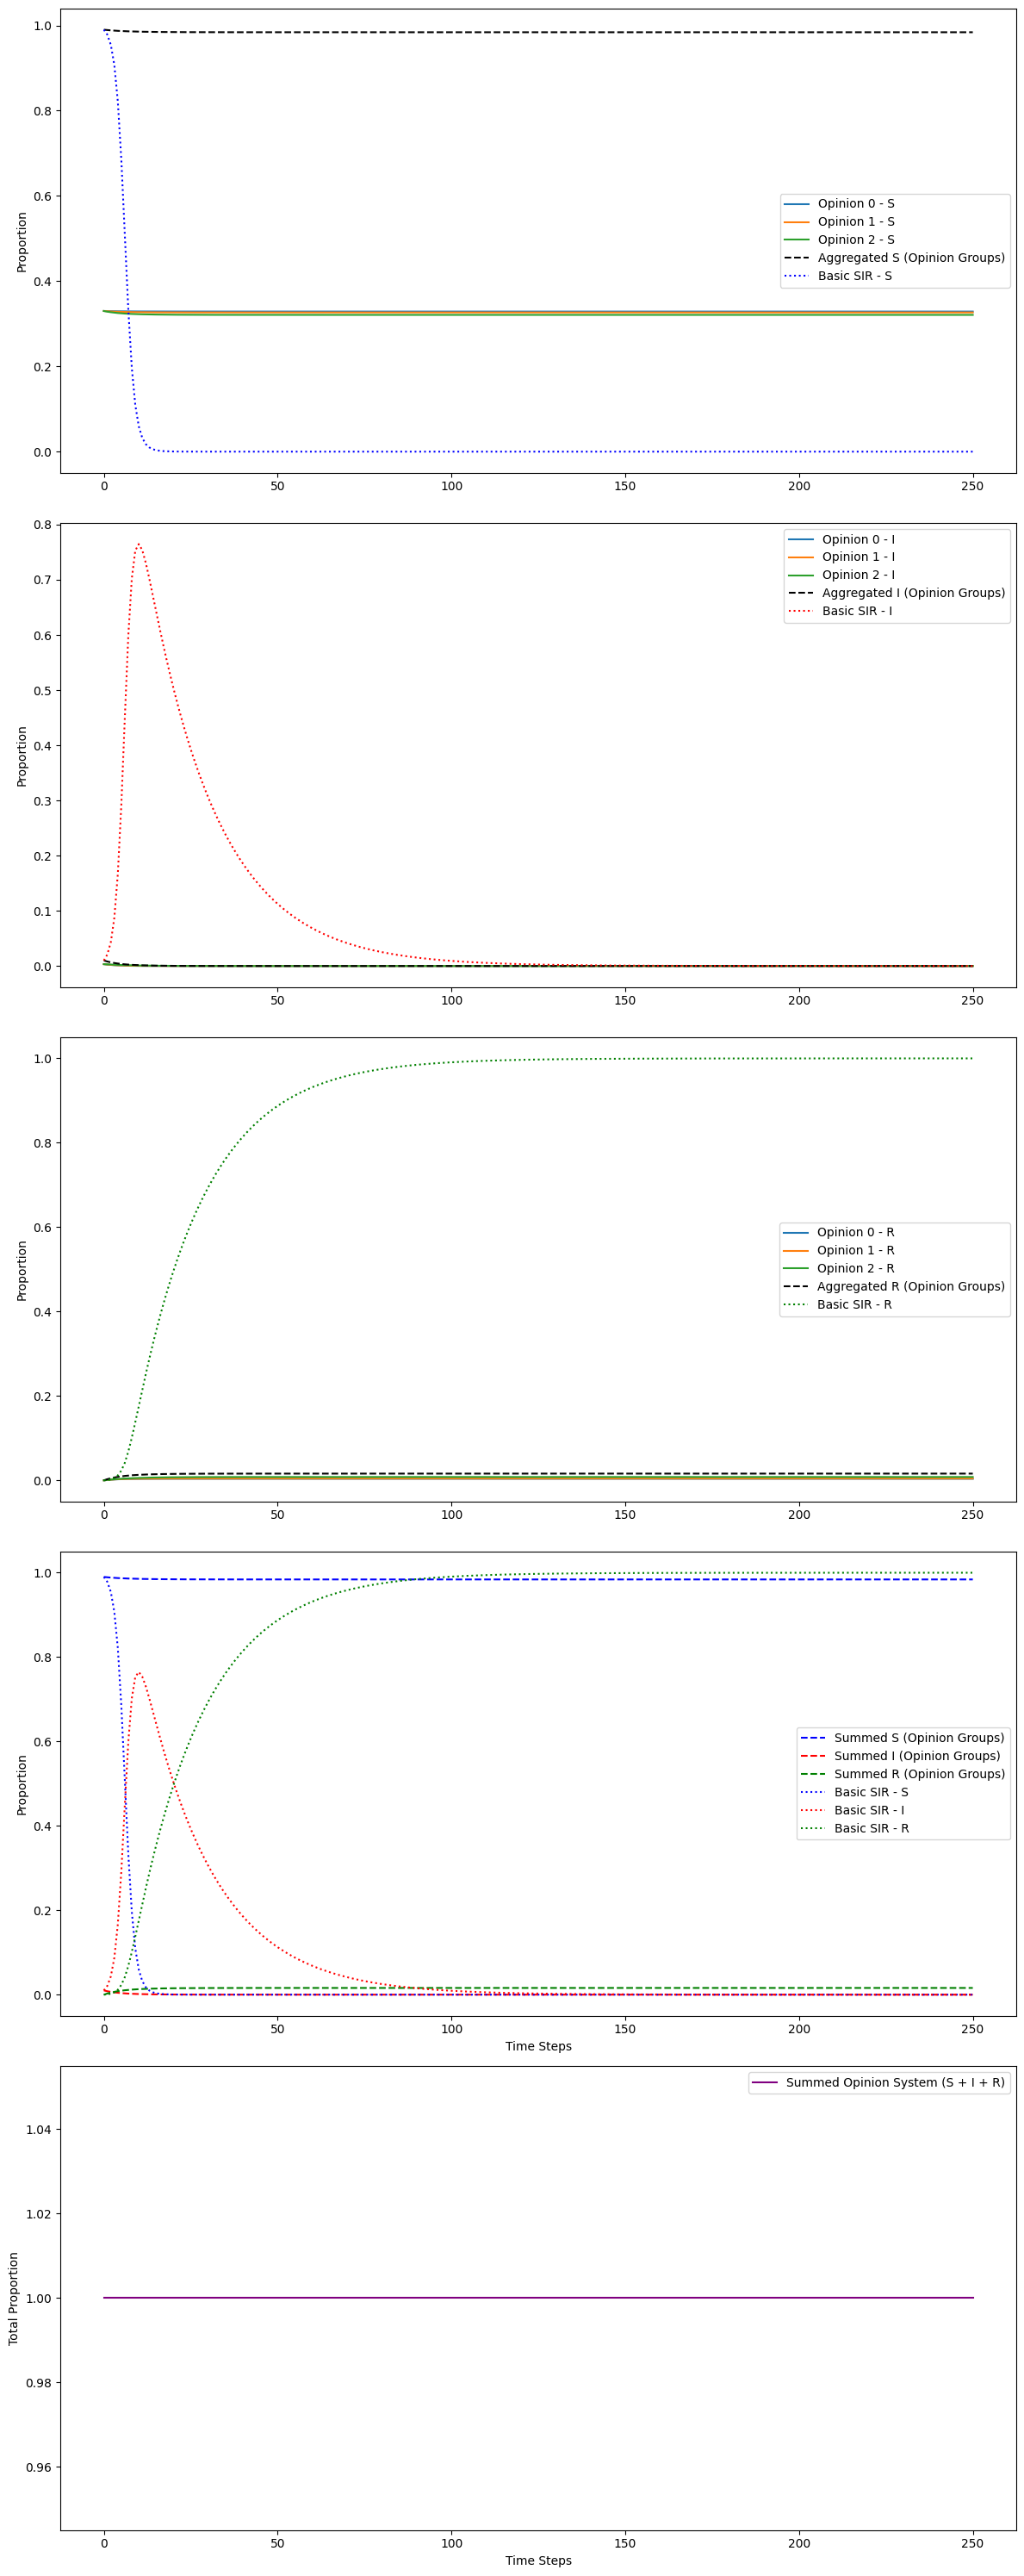

Optimized Beta: 1.0
Optimized Gamma: 0.0


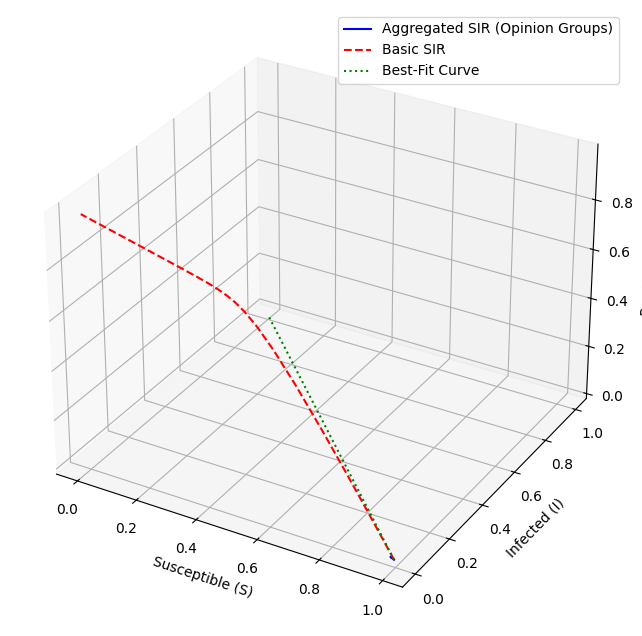

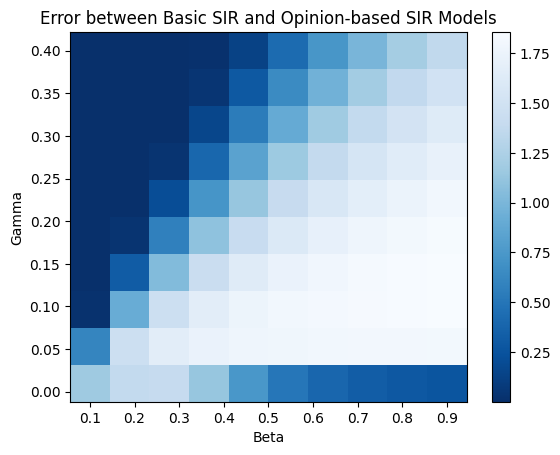

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Basic SIR model parameters and initial values
N = 1
int_I = 0.01 * N
int_R = 0
int_S = N - int_I - int_R
beta = 0.8
gamma = 0.05
MaxTime = 250
RunTime = np.linspace(0, MaxTime, MaxTime)

# Number of opinion groups (indexed from 0 to n)
n = 2  # The total number of opinion groups

# Probability distribution over the opinions
def pi(q, n):
    return np.exp(q) / np.sum(np.exp(np.arange(n + 1)))

# Initialization of initial values for all the S, I, R in each opinion group
initial_values = {f'P_S_{i}': int_S / (n + 1) for i in range(n + 1)}
initial_values.update({f'P_I_{i}': int_I / (n + 1) for i in range(n + 1)})
initial_values.update({f'P_R_{i}': int_R / (n + 1) for i in range(n + 1)})

# Convert initial_values to a list
initial_conditions = [initial_values[f'P_S_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_I_{i}'] for i in range(n + 1)] + \
                     [initial_values[f'P_R_{i}'] for i in range(n + 1)]

# Differential equations for the SIR model with opinions
def sir_opinion_system(y, t, N, beta, gamma, n):
    S = y[:n + 1]
    I = y[n + 1:2 * (n + 1)]
    R = y[2 * (n + 1):]
    
    dSdt = np.zeros(n + 1)
    dIdt = np.zeros(n + 1)
    dRdt = np.zeros(n + 1)
    
    for i in range(n + 1):
        dSdt[i] = -pi(i, n) * beta * S[i] * np.sum(I) / N
        dIdt[i] = pi(i, n) * beta * I[i] * np.sum(S) / (3 * N) - (3*n) * gamma * I[i]
        dRdt[i] = (3*n) *gamma * I[i]
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Integrate the system of differential equations for the SIR model with opinions
result = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta, gamma, n))

# Extract S, I, R for each opinion group
S = result[:, :n + 1]
I = result[:, n + 1:2 * (n + 1)]
R = result[:, 2 * (n + 1):]

# Aggregate the opinion-based model values
aggregated_S = S.sum(axis=1)
aggregated_I = I.sum(axis=1)
aggregated_R = R.sum(axis=1)

# Normalize the summed opinion system so that it does not exceed N
aggregated_total = aggregated_S + aggregated_I + aggregated_R
n_factor = N / aggregated_total
aggregated_n_S = aggregated_S * n_factor
aggregated_n_I = aggregated_I * n_factor
aggregated_n_R = aggregated_R * n_factor

# Sum of S, I, R values from the opinion groups model
summed_opinion_system = aggregated_n_S + aggregated_n_I + aggregated_n_R

# Integrate the system of differential equations for the basic SIR model
def Find_Deriv(y, RunTime, N, beta, gamma):
    int_S, int_I, int_R = y
    dsdt = -beta * int_S * int_I / N
    didt = (beta * int_S * int_I / N) - (gamma * int_I)
    drdt = gamma * int_I
    return dsdt, didt, drdt

# Initial conditions for the basic SIR model
y_0 = int_S, int_I, int_R

# Integrate the system of differential equations for the basic SIR model
coord = odeint(Find_Deriv, y_0, RunTime, args=(N, beta, gamma))
basic_S, basic_I, basic_R = coord.T

# Function to plot the simulation results
def plot_simulation_combined(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n):
    fig, axes = plt.subplots(5, 1, figsize=(12, 30))

    # Plot S, I, R for each opinion group
    for i in range(n + 1):
        axes[0].plot(RunTime, S[:, i], label=f'Opinion {i} - S')
        axes[1].plot(RunTime, I[:, i], label=f'Opinion {i} - I')
        axes[2].plot(RunTime, R[:, i], label=f'Opinion {i} - R')

    # Plot aggregated opinion-based model values
    axes[0].plot(RunTime, aggregated_n_S, label='Aggregated S (Opinion Groups)', color='black', linestyle='--')
    axes[1].plot(RunTime, aggregated_n_I, label='Aggregated I (Opinion Groups)', color='black', linestyle='--')
    axes[2].plot(RunTime, aggregated_n_R, label='Aggregated R (Opinion Groups)', color='black', linestyle='--')

    # Plot basic SIR model results
    axes[0].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[1].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[2].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')

    # Set labels and legend for individual plots
    for i in range(3):
        axes[i].set_ylabel('Proportion')
        axes[i].legend()

    # Plot summed SIR proportions separately
    axes[3].plot(RunTime, aggregated_n_S, label='Summed S (Opinion Groups)', color='blue', linestyle='--')
    axes[3].plot(RunTime, aggregated_n_I, label='Summed I (Opinion Groups)', color='red', linestyle='--')
    axes[3].plot(RunTime, aggregated_n_R, label='Summed R (Opinion Groups)', color='green', linestyle='--')
    axes[3].plot(RunTime, basic_S, label='Basic SIR - S', color='blue', linestyle=':')
    axes[3].plot(RunTime, basic_I, label='Basic SIR - I', color='red', linestyle=':')
    axes[3].plot(RunTime, basic_R, label='Basic SIR - R', color='green', linestyle=':')
    axes[3].set_xlabel('Time Steps')
    axes[3].set_ylabel('Proportion')
    axes[3].legend()

    # Plot summed opinion system
    axes[4].plot(RunTime, summed_opinion_system, label='Summed Opinion System (S + I + R)', color='purple')
    axes[4].set_xlabel('Time Steps')
    axes[4].set_ylabel('Total Proportion')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Plot the results for both the basic SIR model and the opinion groups SIR model
plot_simulation_combined(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, summed_opinion_system, RunTime, n)

# Define the objective function to calculate MSE between models
def objective(params):
    beta_a, gamma_a = params
    
    # Solve the basic SIR model with the given beta and gamma
    sol_basic = odeint(Find_Deriv, y_0, RunTime, args=(N, beta_a, gamma_a))
    S_basic, I_basic, R_basic = sol_basic.T
    
    # Solve the opinion-based SIR model with the given beta and gamma
    sol_opinion = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, beta_a, gamma_a, n))
    S_opinion = sol_opinion[:, :n + 1]
    I_opinion = sol_opinion[:, n + 1:2 * (n + 1)]
    R_opinion = sol_opinion[:, 2 * (n + 1):]
    
    
    aggregated_S = S_opinion.sum(axis=1)
    aggregated_I = I_opinion.sum(axis=1)
    aggregated_R = R_opinion.sum(axis=1)
    aggregated_total = aggregated_S + aggregated_I + aggregated_R
    n_factor = N / aggregated_total
    aggregated_n_S = aggregated_S * n_factor
    aggregated_n_I = aggregated_I * n_factor
    aggregated_n_R = aggregated_R * n_factor

    # Compute the error (MSE) between the models
    error = np.mean((S_basic - aggregated_n_S)**2 + (I_basic - aggregated_n_I)**2 + (R_basic - aggregated_n_R)**2)
    
    return error

# Initial guess for the optimization
initial_guess = [0.7, 0.01]

# Perform the optimization to find the best-fit beta and gamma values
result = minimize(objective, initial_guess, bounds=[(0, N), (0, N)])
optimized_beta, optimized_gamma = result.x

print(f"Optimized Beta: {optimized_beta}")
print(f"Optimized Gamma: {optimized_gamma}")

# Recompute the best-fit curves using the optimized parameters
sol_basic = odeint(Find_Deriv, y_0, RunTime, args=(N, optimized_beta, optimized_gamma))
S_basic_opt, I_basic_opt, R_basic_opt = sol_basic.T

sol_opinion = odeint(sir_opinion_system, initial_conditions, RunTime, args=(N, optimized_beta, optimized_gamma, n))
S_opinion_opt = sol_opinion[:, :n + 1]
I_opinion_opt = sol_opinion[:, n + 1:2 * (n + 1)]
R_opinion_opt = sol_opinion[:, 2 * (n + 1):]

# Aggregate and normalize the opinion-based model values
aggregated_S_opt = S_opinion_opt.sum(axis=1)
aggregated_I_opt = I_opinion_opt.sum(axis=1)
aggregated_R_opt = R_opinion_opt.sum(axis=1)

aggregated_total_opt = aggregated_S_opt + aggregated_I_opt + aggregated_R_opt
n_factor_opt = N / aggregated_total_opt
aggregated_n_S_opt = aggregated_S_opt * n_factor_opt
aggregated_n_I_opt = aggregated_I_opt * n_factor_opt
aggregated_n_R_opt = aggregated_R_opt * n_factor_opt

def plot_3d_combined_with_fit(aggregated_S, aggregated_I, aggregated_R, basic_S, basic_I, basic_R, fitted_S, fitted_I, fitted_R):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the trajectory in the SIR phase space for the opinion groups model
    ax.plot(aggregated_S, aggregated_I, aggregated_R, label='Aggregated SIR (Opinion Groups)', color='blue')
    
    # Plot the trajectory in the SIR phase space for the basic SIR model
    ax.plot(basic_S, basic_I, basic_R, label='Basic SIR', color='red', linestyle='--')
    
    # Plot the best-fit curve
    ax.plot(fitted_S, fitted_I, fitted_R, label='Best-Fit Curve', color='green', linestyle=':')
    
    # Label the axes
    ax.set_xlabel('Susceptible (S)')
    ax.set_ylabel('Infected (I)')
    ax.set_zlabel('Recovered (R)')
    
    ax.legend()
    plt.show()

# Call the plotting function with optimized parameters
plot_3d_combined_with_fit(aggregated_n_S, aggregated_n_I, aggregated_n_R, basic_S, basic_I, basic_R, aggregated_n_S_opt, aggregated_n_I_opt, aggregated_n_R_opt)

# Define the range of beta and gamma values for the grid search
beta_vals = np.linspace(0.1, 0.9, 10)
gamma_vals = np.linspace(0.01, 0.4, 10)
errors = np.zeros((len(beta_vals), len(gamma_vals)))

# Compute the error for each combination of beta and gamma values
for i, beta_a in enumerate(beta_vals):
    for j, gamma_a in enumerate(gamma_vals):
        errors[i, j] = objective([beta_a, gamma_a])

# Plot the error heatmap
fig, ax = plt.subplots()
c = ax.pcolormesh(beta_vals, gamma_vals, errors.T, cmap='Blues_r', shading='auto')
ax.set_xlabel('Beta')
ax.set_ylabel('Gamma')
fig.colorbar(c, ax=ax)
plt.title('Error between Basic SIR and Opinion-based SIR Models')
plt.show()
